In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch as tch
from torch import nn, Tensor

In [3]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use("dark_background")

In [4]:
dev = tch.device("cuda")
dtype = tch.float32

In [5]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

In [6]:
def make_images(img: np.ndarray) -> Tensor:
    return tch.from_numpy(img).to(dev).type(dtype) / 255.0

In [14]:
class CopyGrad(tch.autograd.Function):
    @staticmethod
    def forward(ctx, x: Tensor, copy_grad_to: Tensor) -> Tensor:
        assert x.shape == copy_grad_to.shape, f"Shape mismatch: x ({x.shape}) != copy_grad_to ({copy_grad_to.shape})"
        return x
    
    @staticmethod
    def backward(ctx, grad: Tensor) -> tuple[Tensor, Tensor]:
        return (grad, grad)

def copy_grad(x: Tensor, copy_grad_to: Tensor) -> Tensor:
    return CopyGrad.apply(x, copy_grad_to)

def quantize_latent(dictionary: nn.Embedding, x: Tensor) -> Tensor:
    """
    x.shape: (batch_size, n_vecs * vec_dim)
    output shape is the same as x.shape
    """
    emb = dictionary.weight # (dict_size, vec_dim)

    emb_ = emb.reshape((1, 1, *emb.shape)) # (1, 1, dict_size, vec_dim)
    x_ = x.reshape((x.shape[0], x.shape[1] // emb.shape[1], 1, emb.shape[1])) # (batch_size, n_vecs, 1, vec_dim)

    dist = tch.norm(emb_ - x_, 2, dim=-1) # (batch_size, n_vecs, dict_size)
    indices = dist.argmin(-1) # (batch_size, n_vecs)

    qx = emb[indices] # (batch_size, n_vecs, vec_dim)

    return qx.flatten(1)


x = 4.0 * tch.randn((2, 3 * 4)).type(tch.float32)
x.requires_grad = True

emb = nn.Embedding.from_pretrained(tch.arange(-2, 3).broadcast_to((4, 5)).t().type(tch.float32))
emb.weight.requires_grad = True

y = quantize_latent(emb, x)
print(y)

y = copy_grad(y, x)
y.retain_grad()
(y * tch.randn_like(y)).flatten().sum(0).backward()

print(f"{y.grad = }")
print(f"{x.grad = }")
print(f"{emb.weight.grad = }")


tensor([[-2., -2., -2., -2.,  0.,  0.,  0.,  0., -1., -1., -1., -1.],
        [ 2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., -2., -2., -2., -2.]],
       grad_fn=<ViewBackward0>)
y.grad = tensor([[ 0.6872,  0.1389,  0.0039, -0.7532, -0.9173, -1.0677, -1.3377, -1.1987,
          0.7670, -1.1989, -0.0218, -0.4148],
        [-1.2482, -0.8820,  0.4299, -0.4476,  0.6630, -1.1138,  0.2406,  1.0958,
         -0.7577, -0.1801, -0.2900, -0.7197]])
x.grad = tensor([[ 0.6872,  0.1389,  0.0039, -0.7532, -0.9173, -1.0677, -1.3377, -1.1987,
          0.7670, -1.1989, -0.0218, -0.4148],
        [-1.2482, -0.8820,  0.4299, -0.4476,  0.6630, -1.1138,  0.2406,  1.0958,
         -0.7577, -0.1801, -0.2900, -0.7197]])
emb.weight.grad = tensor([[-0.0705, -0.0412, -0.2861, -1.4729],
        [ 0.7670, -1.1989, -0.0218, -0.4148],
        [-0.9173, -1.0677, -1.3377, -1.1987],
        [ 0.6630, -1.1138,  0.2406,  1.0958],
        [-1.2482, -0.8820,  0.4299, -0.4476]])


In [15]:
def sample_fig(enc: nn.Module, dec: nn.Module, dictionary: nn.Embedding, x: Tensor):
    enc.train(False)
    dec.train(False)
    dictionary.train(False)

    z = enc.forward(x)
    qz = quantize_latent(dictionary, z)
    y = dec.forward(qz).sigmoid()

    in_imgs = x.detach().cpu().numpy()
    out_imgs = y.detach().cpu().numpy()

    fig, axs = plt.subplots(2, x.shape[0])
    for col in range(y.shape[0]):
        for row, img in enumerate([in_imgs[col], out_imgs[col]]):
            ax = axs[row, col]
            ax.axis('off')
            ax.imshow(img, interpolation='nearest')

    return fig

In [19]:
from genpg.model import Encoder, Decoder

image_dims = test_images.shape[1:]
latent_dims = [16, 16]
dict_size = 256

conv_channels = [[1, 8, 8, 8], [8, 16], [16, 32]]
kernel_size = 3
fc_dims = [2 * 784, 1024]

enc = Encoder(image_dims, conv_channels, kernel_size, [*fc_dims, np.prod(latent_dims)]).to(dev)
print(enc)
dec = Decoder([np.prod(latent_dims), *reversed(fc_dims)], [list(reversed(s)) for s in reversed(conv_channels)], kernel_size, image_dims).to(dev)
print(dec)
dictionary = nn.Embedding(dict_size, latent_dims[1]).to(dev)

Encoder(
  (conv): ConvNet(
    (0): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (3): ReLU()
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
  )
  (mlp): Mlp(
    (0): Linear(in_features=1568, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
  )
)
Decoder(
  (mlp): Mlp(
   

In [20]:
batch_size = 256
comm_factor = 0.01

optim = tch.optim.AdamW(
    list(enc.parameters()) + list(dec.parameters()) + list(dictionary.parameters()),
    lr=1e-3,
)

'epoch = 39'

{'reconstruction_loss': np.float64(0.00407095082262729),
 'codebook_loss': np.float64(0.11102635695579204),
 'commitment_loss': np.float64(0.0011102635448085184),
 'total_loss': np.float64(0.1162075713276863)}

{'loss': np.float64(0.004355463187675923)}

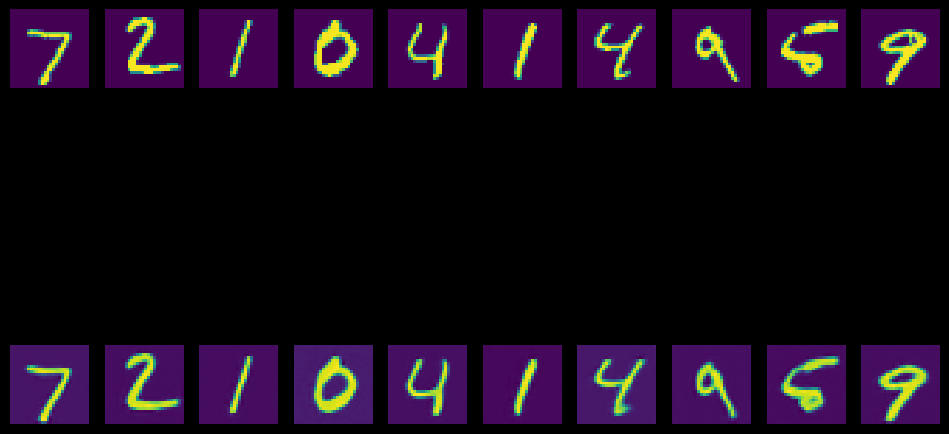

In [21]:
from torch.nn.functional import mse_loss, binary_cross_entropy_with_logits as bce_with_logits
from genpg.dataset import generate_batches
from genpg.utils import Accum
from genpg.notebook import Display

test_x = make_images(test_images[:10])
display = Display()

for epoch in range(40):

    enc.train(True)
    dec.train(True)
    dictionary.train(True)

    train_stats = Accum("reconstruction_loss", "codebook_loss", "commitment_loss", "total_loss")
    for labels, images in generate_batches(batch_size, train_labels, train_images):
        images = make_images(images)

        enc.zero_grad()
        dec.zero_grad()
        dictionary.zero_grad()

        x = images
        z = enc.forward(x)
        qz = quantize_latent(dictionary, z)
        y = dec.forward(copy_grad(qz.detach(), z))

        rec_loss = mse_loss(y, x)
        dict_loss = mse_loss(z.detach(), qz)
        comm_loss = comm_factor * mse_loss(z, qz.detach())
        loss = rec_loss + dict_loss + comm_loss

        loss.backward()
        optim.step()

        train_stats.append(rec_loss.item(), dict_loss.item(), comm_loss.item(), loss.item())

    enc.train(False)
    dec.train(False)
    dictionary.train(False)

    val_stats = Accum("loss")
    for labels, images in generate_batches(batch_size, test_labels, test_images):
        images = make_images(images)
        
        x = images
        z = enc.forward(x)
        qz = quantize_latent(dictionary, z)
        y = dec.forward(qz)

        loss = mse_loss(y, x)

        val_stats.append(loss.item())

    fig = sample_fig(enc, dec, dictionary, test_x)

    display.clear()
    display.update(f"{epoch = }")
    display.update(train_stats.mean())
    display.update(val_stats.mean())
    display.update(fig)
    plt.close()

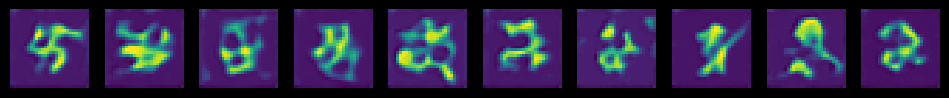

In [24]:
# sample random latent point

dec.train(False)
dictionary.train(False)

n = 10
z = tch.randn((n, np.prod(latent_dims)), device=dev)
qz = quantize_latent(dictionary, z)
y = dec.forward(qz).sigmoid()

images = y.detach().cpu().numpy()
fig, axs = plt.subplots(1, y.shape[0])
for i in range(y.shape[0]):
    ax = axs[i]
    ax.axis('off')
    ax.imshow(images[i], interpolation='nearest')

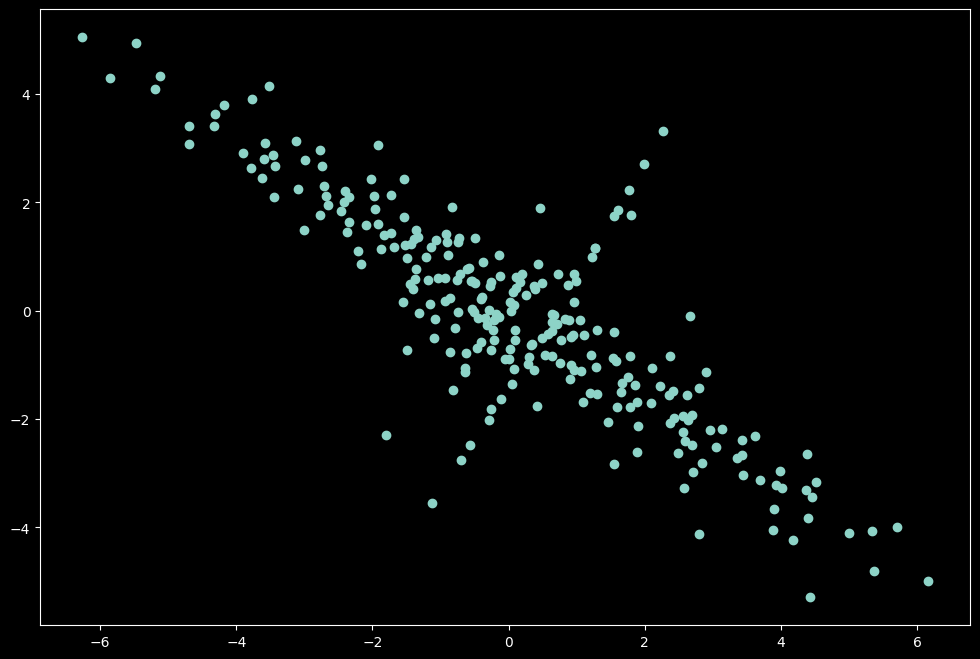

In [27]:
n = 1000
c = test_labels[:n]
z = dictionary.weight.detach().cpu().numpy()

x, y = z[:,0], z[:,1]
plt.scatter(x, y)